# SyriaTel Customer Churn Project - Modeling

This notebook is the modeling step for this project. We take the cleaned data CSV that was processed through the other [notebook](01_syriatel_customer_churn_data_cleaning.ipynb) and run the data through several different model to find the best one to predict if a customer will churn.

### Authors

* Tony Bai
* Arthur Kim
* Eddie Lin
* Douglas Lu

## Imports

In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import xgboost as xg
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, plot_confusion_matrix
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline

import warnings

In [2]:
warnings.filterwarnings("ignore")

## Data Manipulation

Here we load the cleaned data CSV file.

In [3]:
#load the data
df = pd.read_csv('data/syrialtel_cleaned_data.csv')

In [4]:
#review the first few entires of the data
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_calls,total_charge,charge_per_min_day,charge_per_min_eve,charge_per_min_night,charge_per_min_dom,charge_per_min_int,%_int_min,call_satisfaction,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,303,75.56,0.409727,0.169495,0.120989,0.242867,0.900000,1.394311,0.330033,Midwest
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,332,59.24,0.223333,0.161359,0.111165,0.168815,1.233333,2.191299,0.301205,Midwest
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,333,62.29,0.362982,0.093636,0.070385,0.179878,0.658000,2.261772,0.000000,Northeast
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,255,66.80,0.716901,0.059773,0.099551,0.262177,0.254286,1.168555,0.784314,Midwest
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,359,52.09,0.250796,0.103361,0.069504,0.138652,0.910000,1.972656,0.835655,South


The data is split to a train and test data for analysis.

In [5]:
#seperating the target and data
X = df.drop('churn', axis=1)
y = df['churn']

#creating a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Splitting the Data Between Categorical and Continuous

We split the data between categorical and continuous features to allow us for proper preprocessing through pipelines.

In [6]:
categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
df_cat = X_train[categorical]
df_cont = X_train.drop(categorical,axis = 1)

In [7]:
#splitting the numericals and categoricals
X_num = df_cont.columns
X_cat = df_cat.columns

## Pipeline

We are creating a pipeline to process the categorical and continuous variable. This pipeline scales the data and creates a one hot encoder.

In [8]:
#preprocessing the pipeline with standard scaler and one hot encoder
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [9]:
# transform the pipeline and then converting it back into a dataframe
X_train_scaled = pp.fit_transform(X_train)
X_test_scaled = pp.transform(X_test)

Using the pipeline, we need to match the columns with their respective column names. The order in which we process the data is important so we check to see whether categorical categories or the continuous comes first.

In [10]:
pd.DataFrame(X_train_scaled).head(2)

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,-0.511937,-0.585483,0.410716,0.873749,0.410877,1.167102,-1.646317,1.167733,-0.456961,0.615443,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.939002,-0.585483,-0.864713,1.074874,-0.865095,-2.639021,-1.895351,-2.637901,-0.790790,1.075039,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We see that the continuous features come first and match the column names

In [11]:
# aggregating col names from the one hot encode 
cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
feature_names= list(X_num) + cat_names

# renaming the data frame with corresponding col names
X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

In [12]:
feature_names

['account_length',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_calls',
 'total_day_charge',
 'total_eve_minutes',
 'total_eve_calls',
 'total_eve_charge',
 'total_night_minutes',
 'total_night_calls',
 'total_night_charge',
 'total_intl_minutes',
 'total_intl_calls',
 'total_intl_charge',
 'customer_service_calls',
 'total_minutes_dom',
 'total_calls_dom',
 'total_charge_dom',
 'total_minutes',
 'total_calls',
 'total_charge',
 'charge_per_min_day',
 'charge_per_min_eve',
 'charge_per_min_night',
 'charge_per_min_dom',
 'charge_per_min_int',
 '%_int_min',
 'call_satisfaction',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ

## Functions

The scores function was created to show the log loss, accuracy, precision, and recall for all the models as well as a confusion matrix to compare the train and test data.

In [13]:
def scores(model, actual = y_test ,X_train_scaled = X_train_scaled, X_test_scaled = X_test_scaled,y_train = y_train):
    pred_train = model.predict(X_train_scaled)
    pred_test = model.predict(X_test_scaled)
    
    print("Train Scores")
    print("log loss: ", log_loss(y_train, pred_train))
    print("accuracy: ", accuracy_score(y_train, pred_train))
    print("precision:", precision_score(y_train, pred_train))
    print("recall:   ", recall_score(y_train, pred_train))
    plot_confusion_matrix(model, X_train_scaled, y_train)
    
    print("Test Scores")
    print("log loss: ", log_loss(actual, pred_test))
    print("accuracy: ", accuracy_score(actual, pred_test))
    print("precision:", precision_score(actual, pred_test))
    print("recall:   ", recall_score(actual, pred_test))
    
    
    plot_confusion_matrix(model, X_test_scaled, actual)

The plot_feature_importances was created to pull the important features from the model to see what factors drive the model.

In [14]:
def plot_feature_importances(model):
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_scaled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

## Model 1: Dummy model

The dummy model is created to assume the most frequent category. We can see that since the data is skewed, the accuracy is at 85% just by predicting no churn across the data.

Train Scores
log loss:  5.033512205001985
accuracy:  0.8542648949849978
precision: 0.0
recall:    0.0
Test Scores
log loss:  4.939045024472227
accuracy:  0.857
precision: 0.0
recall:    0.0


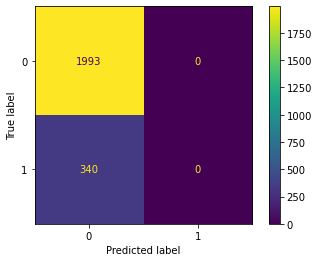

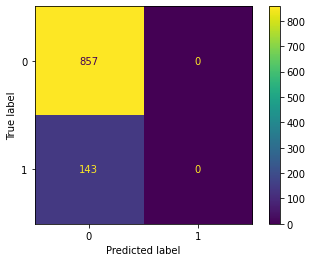

In [15]:
##We create a dummy model of our data
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)

#y_preds_dum= dummy_clf.predict(X_test)

scores(dummy_clf);

#from this data we can see that the data is skewed
#and has a 85% accuracy of predicting correctly when 
#assuming one category

## Model 2:  Log Regression

We start off by using a simple log Regression to see how it performs.

In [16]:
## Here we use a basic Log Regresion used a baseline log regression model to test out the data
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

logreg_cv = cross_val_score(logreg, X_train_scaled, y_train).mean()
print(logreg_cv)

0.8636884138552169


Train Scores
log loss:  4.248891901939016
accuracy:  0.8769824260608658
precision: 0.6853146853146853
recall:    0.28823529411764703
Test Scores
log loss:  4.593675651264016
accuracy:  0.867
precision: 0.5892857142857143
recall:    0.23076923076923078


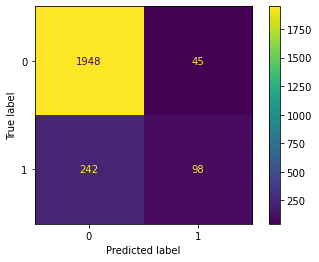

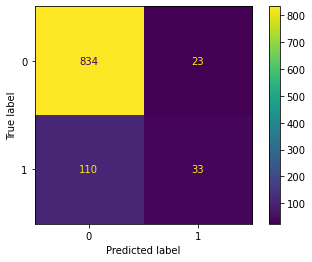

In [17]:
scores(logreg,y_test)

While the accuracy score is better than the dummy model, this is only slightly better and the recall score is very low.

### Recall is KEY

We have decided to look at recall for our main metric. As a telecom company trying to reduce churn, we care about the recall of our model. Recall is defined as the TP/(TP+FN). We are trying to minimize False Negatives (FN) here, meaning that we want to reduce the number of people that our model predicts will not churn but are actually likely to do so. This is because we want to send out promotions to retain customers and we do not want to miss any potential customers who are likely to churn.

## Model 3: K-Nearest Neighbors without SMOTE

The Gridsearch for the KNN model is commented out due to the long run time for the search. The best parameters from the search has been selected and assigned below.

In [18]:
### initate the model with no parameters

# knn_model = KNeighborsClassifier()


# # initiate grid and grid search
# param_grid = {
#     'n_neighbors': list(range(1, 20, 2)),
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2, 3, 4],
# }


# gs_knn = GridSearchCV(knn_model, param_grid=param_grid, cv=5)
# gs_knn.fit(X_train_scaled, y_train)

# gs_knn.best_params_

In [19]:
best_knn = KNeighborsClassifier(n_neighbors = 7,
                                p = 1,
                                weights = 'uniform') 
best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=7, p=1)

Train Scores
log loss:  3.1977634368110373
accuracy:  0.9074153450492928
precision: 0.9428571428571428
recall:    0.38823529411764707
Test Scores
log loss:  3.4193404622910184
accuracy:  0.901
precision: 0.9583333333333334
recall:    0.32167832167832167


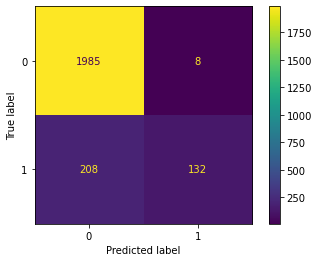

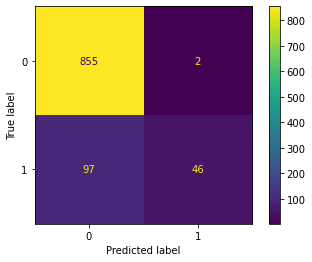

In [20]:
scores(best_knn,y_test)

This model is even better than the logistic regression in both accuracy and the recall score, however it is still too low. This may have been caused because of a class imbalance so we will run the model again but implementing SMOTENCto reduce that.

## Model 4: K-Nearest Neighbors with SMOTE

In [21]:
# calculate the current ratio of imbalance for SMOTE 
round(len(y_train[y_train==1])/len(y_train[y_train==0]),2)

0.17

We take a look at the feature names in the 'Pipeline section' above and selected the columns that were categorical. This turns out to be all the column from 28 onward.

In [22]:
# SMOTE the categorical columns by their index
cat_range = range(28,57)
smote = SMOTENC(np.array(cat_range),random_state=42, sampling_strategy=0.5)
# X_train_resampled, y_train_resampled = smote.fit_sample(X_traain_scaled, y_train)

A new pipeline was created to incorporate SMOTENC

In [23]:
# Rerun the KNN Model with SMOTED DATA

knn_model_smote = imbpipeline(steps=[
        ("Preprocess", pp),
        ('sampling', smote),
        ('knn', KNeighborsClassifier())
    ])


In [24]:
knn_model_smote.fit(X_train,y_train)

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_int...
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['state', 'area_code', 'international_plan', 'voice_mail_plan',
       'region'],
      dtype='object'

In [25]:
# #perform a grid search again to see if criteria changed
# param_grid = {
#     'knn__n_neighbors': list(range(2, 100, 2)),
#     'knn__weights': ['uniform', 'distance'],
#     'knn__p': [1, 2, 3, 4],
# }

# gs_knn = GridSearchCV(knn_model_smote, param_grid, cv=2, scoring='recall')

In [26]:
# gs_knn.fit(X_train, y_train)

# gs_knn.best_params_

The code above is a gridsearch for the KNN smote model. The gridsearch takes a long time to complete thus the best parameters have already been set below.

In [27]:
#best knn smote model obtained from the gridsearch above
best_knn_sm = KNeighborsClassifier(n_neighbors= 32, p = 2, weights= 'distance')

In [28]:
best_knn_sm.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=32, weights='distance')

Train Scores
log loss:  9.992007221626415e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  4.248270296171444
accuracy:  0.877
precision: 0.9545454545454546
recall:    0.14685314685314685


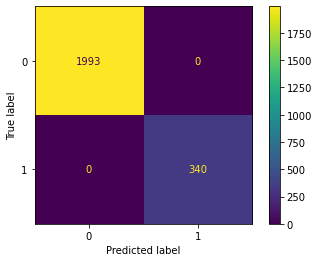

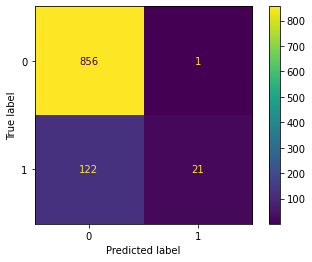

In [29]:
scores(best_knn_sm)

We prioritize the the recall in the gridsearch and the SMOTE-NC KNN model is overfit. The accuracy is high on the trainning data, and the test set performs worse.

After applying SMOTENC to the data, the model performed significantly worse on the test set for recall.

## Model 5: Decision Tree Model

The KNN Model with SMOTENC performed poorly so we decided to move on to a new model. Here we run a Decision Tree model to see if we have a better fit.

In [30]:
#Here we Instantiate a Decision Tree and run the classifer on our data

DT_clf = DecisionTreeClassifier() 

DT_cv_score_cv = cross_val_score(DT_clf, X_train_scaled, y_train, cv=3).mean()

print(f"Mean Cross Val Score: {DT_cv_score_cv:.2%}")

Mean Cross Val Score: 94.51%


Due to the long runtime of the the Decision Tree Gridsearch, the best selection from the following search was selected for further analysis.

In [31]:
#Create grid search parameters and intantiate GridSearch CV. Create different parameters and then fit the data. 

# DT_clf = DecisionTreeClassifier() 

# param_grid = { 
#     'criterion': ['gini', 'entropy'],
#     'max_depth': np.arange(1, 15, 2), #step up even higher 
#     'min_samples_split': np.arange(5, 120, 5),
#     'min_samples_leaf': np.arange(5, 120,5)
#     }

# gs_DT_clf = GridSearchCV(DT_clf, param_grid = param_grid, n_jobs = -1, scoring = "recall", cv = 5)

# gs_DT_clf.fit(X_train_scaled, y_train)
    


#After running it best parameter = 
# {'criterion': 'entropy',
#  'max_depth': 7,
#  'min_samples_leaf': 5,
#  'min_samples_split': 5}

In [32]:
best_DT_clf = DecisionTreeClassifier(criterion='entropy',
                                    max_depth= 7,
                                    min_samples_leaf= 5,
                                    min_samples_split= 5) 
best_DT_clf.fit(X_train_scaled, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5,
                       min_samples_split=5)

Train Scores
log loss:  0.8438548876552214
accuracy:  0.9755679382768967
precision: 0.9862542955326461
recall:    0.8441176470588235
Test Scores
log loss:  0.5871599983109127
accuracy:  0.983
precision: 0.9921875
recall:    0.8881118881118881


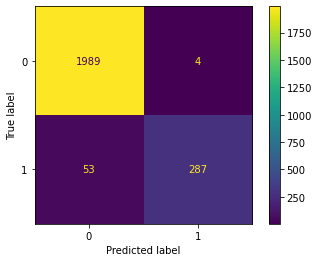

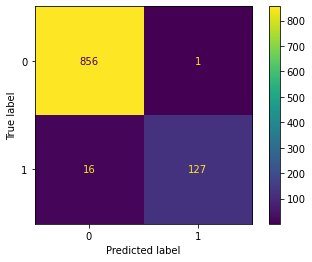

In [33]:
scores(best_DT_clf)

We see here that the decision tree model also giving us high recall as that is the feature we want to focus on.

We will plot the important features and see what drives this model.

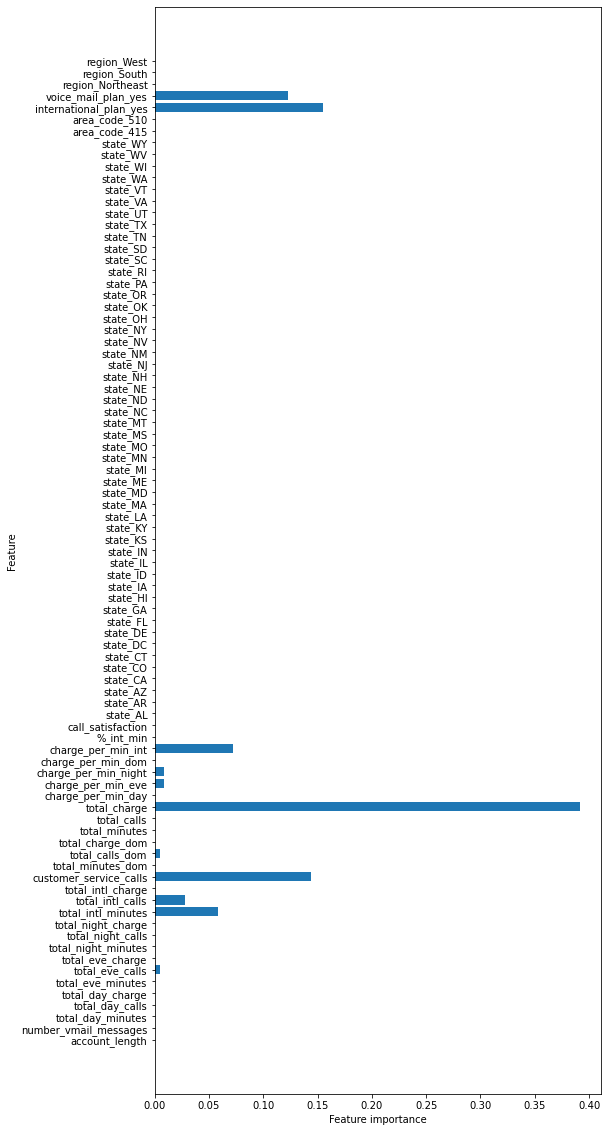

In [34]:
plot_feature_importances(best_DT_clf)

It seems like total charge, international plan status, and customer service calls were the most important features.

## Model 6: Bagged Decision Tree Model

We also tested the bagging classifier model to see how this one stacks up to the other.

Train Scores
log loss:  0.9474846503533157
accuracy:  0.9725675096442349
precision: 1.0
recall:    0.8117647058823529
Test Scores
log loss:  0.6562367515033039
accuracy:  0.981
precision: 1.0
recall:    0.8671328671328671


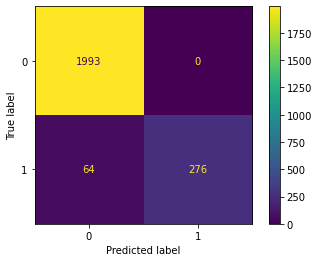

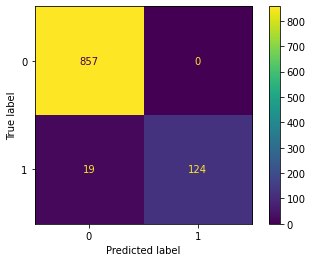

In [35]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', 
                                                       max_depth = 5, 
                                                       min_samples_leaf = 10, 
                                                       min_samples_split = 3), 
                                                       n_estimators = 20)

#Fit the model on training data
bagged_tree.fit(X_train_scaled, y_train)
scores(bagged_tree)


The data is pretty good with good accuracy with both the test and train data, but the recall on the test data performed worse.

## Model 7: Random Forest

We also wanted to see how the random forest classifier performed on our data. We selected some parameters to see how well it did. Since the initial model performed fairly well, we decided to run a gridsearch to find some better parameters.

In [36]:
rf_model = RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 1150, 
                                  max_depth=10, 
                                  bootstrap = True, 
                                  min_samples_split= 7)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7,
                       n_estimators=1150)

Train Scores
log loss:  0.814244621397381
accuracy:  0.9764252036005143
precision: 1.0
recall:    0.8382352941176471
Test Scores
log loss:  1.3815510557964281
accuracy:  0.96
precision: 1.0
recall:    0.7202797202797203


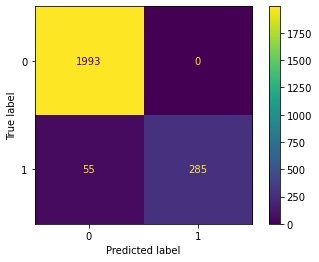

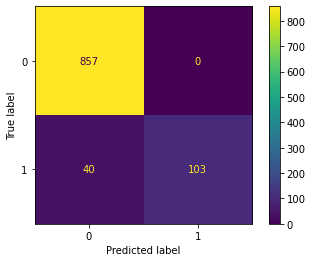

In [37]:
rf_preds = rf_model.predict(X_test_scaled)
scores(rf_model)

In [38]:
# # Grid Search for parameters, Played around with n_estimators before and found the optimal so excluded from this grid search
# grid = {        
#  'max_depth': [8,10],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 7]}

# gs = GridSearchCV(estimator=rf_model, param_grid= grid, cv=2)
# gs.fit(X_train_scaled, y_train)
# gs.best_params_

The gridsearch above was ran and the best parameters for the data was selected for the best random forest model below.

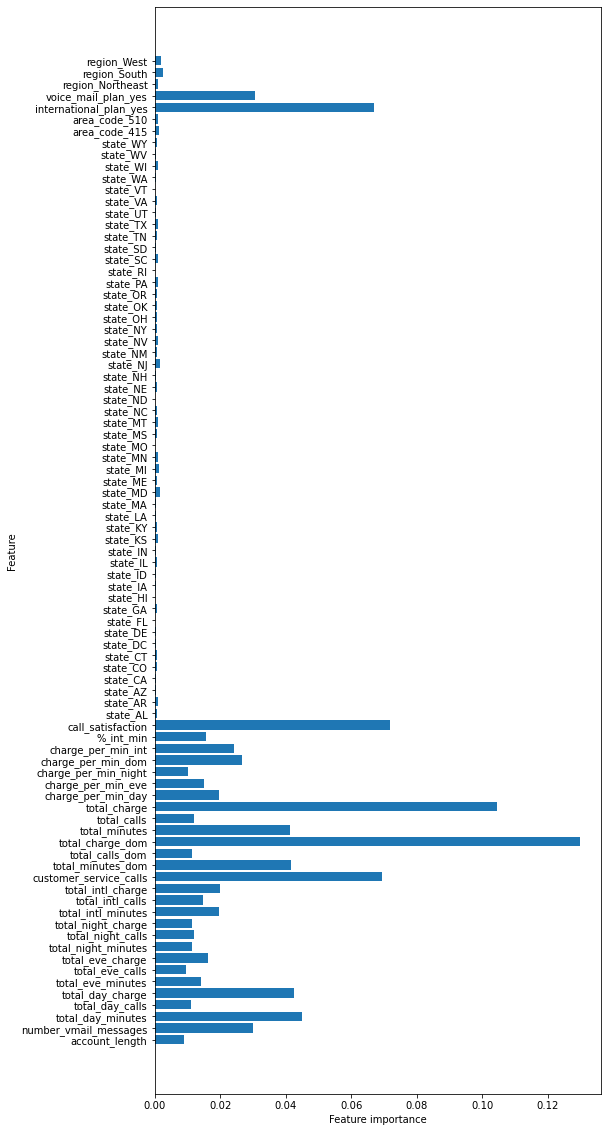

In [39]:

best_rf_model= RandomForestClassifier(max_depth = 10, 
                                   max_features = 'auto',
                                   min_samples_leaf = 1,
                                   min_samples_split = 5)
best_rf_model.fit(X_train_scaled,y_train)

plot_feature_importances(best_rf_model)

## Model 8: XGBoost

We decided to explore the different boosting models.

In [40]:
xgb_model= xg.XGBClassifier(random_state=42, objective='binary:logistic', alpha=2)

In [41]:
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=2, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train Scores
log loss:  0.19245781960301805
accuracy:  0.9944277753964852
precision: 1.0
recall:    0.961764705882353
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


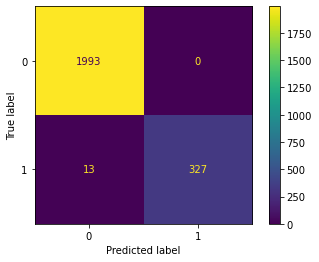

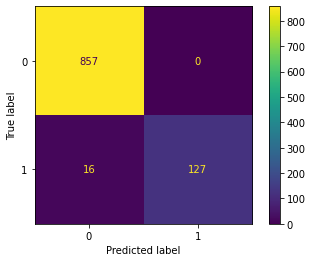

In [42]:
scores(xgb_model)

In [43]:
# grid2 = {'eta': [.05,.1, .2, .4],
#          'max_depth': [3,8,9],
#          'alpha' : [1,2,3,4]
#  }
# gs = GridSearchCV(estimator=xgb_model, param_grid= grid2, cv=2)
# gs.fit(X_train_scaled, y_train)
# gs.best_params_

The gridsearch was run for the XGBoost model and the best parameters was selected for the model below.

In [44]:
best_xg_model = xg.XGBClassifier(alpha = 1, eta = 0.5, max_depth = 8)
best_xg_model.fit(X_train_scaled,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train Scores
log loss:  9.992007221626415e-16
accuracy:  1.0
precision: 1.0
recall:    1.0
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


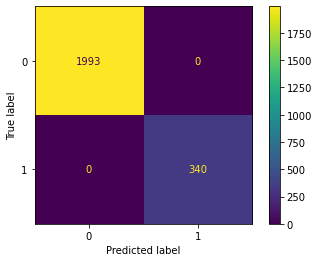

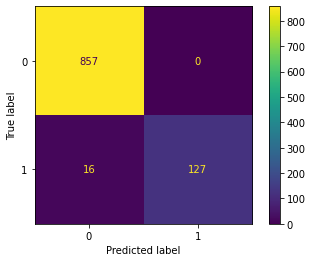

In [45]:
scores(best_xg_model)

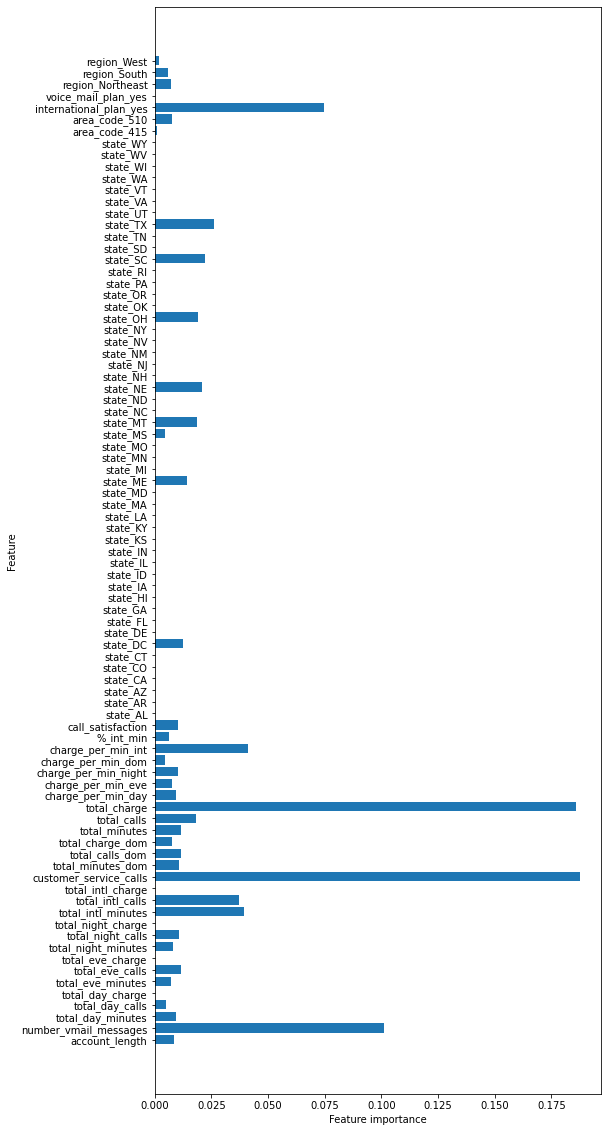

In [46]:
plot_feature_importances(best_xg_model)

Train Scores
log loss:  0.7402223830885283
accuracy:  0.9785683669095585
precision: 1.0
recall:    0.8529411764705882
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


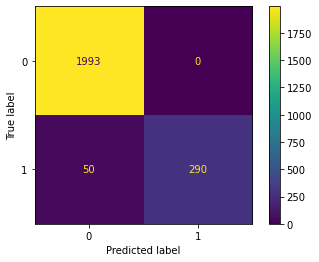

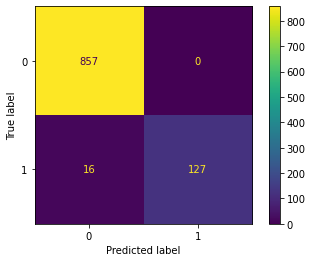

In [47]:
xgb_model= xg.XGBClassifier(random_state=42, objective='binary:hinge', alpha=1, eta =.05, max_depth =3)
xgb_model.fit(X_train_scaled, y_train)
y_preds_xgb = xgb_model.predict(X_test_scaled)
scores(xgb_model)

From the sores above, we see that the model fit perfectly on the training data and the test data performed exceptionally well too.

## Model 9: AdaBoost

We ran a basic ADABoost and found that the scores were not performing as well and decided not to run a gridsearch for this model

In [48]:
model_boost_ada = AdaBoostClassifier(n_estimators=40,random_state=42)
model_boost_ada.fit(X_train_scaled,y_train)

AdaBoostClassifier(n_estimators=40, random_state=42)

Train Scores
log loss:  2.54637802170038
accuracy:  0.9262751821688813
precision: 0.8442622950819673
recall:    0.6058823529411764
Test Scores
log loss:  3.1430478422751973
accuracy:  0.909
precision: 0.76
recall:    0.5314685314685315


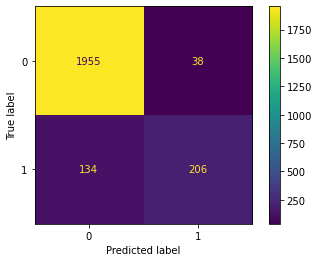

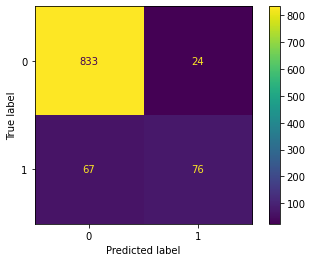

In [49]:
scores(model_boost_ada)

## Model 10: Gradient Boost

Gradient boost model was also tested and this also performed well.

In [50]:
model_boost_gb = GradientBoostingClassifier(random_state=42)
gb_m = model_boost_gb.fit(X_train_scaled,y_train)

In [51]:
gradient_boost_cv = cross_val_score(gb_m, X_train_scaled, y_train, cv = 10)
gradient_boost_cv
gradient_boost_cv.mean()

0.9772862330802244

Train Scores
log loss:  0.6217868017943637
accuracy:  0.9819974282040291
precision: 1.0
recall:    0.8764705882352941
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


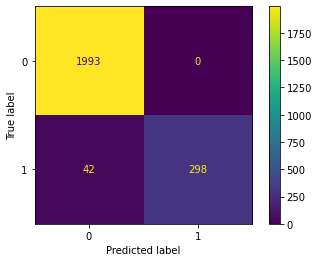

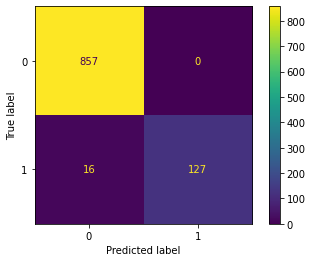

In [52]:
scores(model_boost_gb)

The gradient boost model recall scores were similar to those of the XGBoost model but we decided that the gradient boost model was better because the train and test recall scores were similar meaning that the model was not overfitting on the train data unlike the XGBoost model.

## Model 11: Ensemble

We wanted to see if an ensemble would improve our results by passing through some of the better preforming models.

In [53]:
voting_clf = VotingClassifier(estimators=[ 
                                          ("rf", rf_model) ,
                                          ('dt', best_DT_clf),
                                          ('xgb', xgb_model),
                                          ("gb", gb_m)], 
                                          voting= "soft")

In [54]:
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_split=7,
                                                     n_estimators=1150)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     min_samples_leaf=5,
                                                     min_samples_split=5)),
                             ('xgb',
                              XGBClassifier(alpha=1, base_score=0.5,
                                            booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample

Train Scores
log loss:  0.7402223830885283
accuracy:  0.9785683669095585
precision: 1.0
recall:    0.8529411764705882
Test Scores
log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


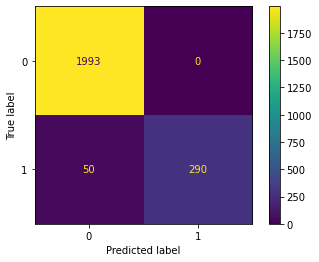

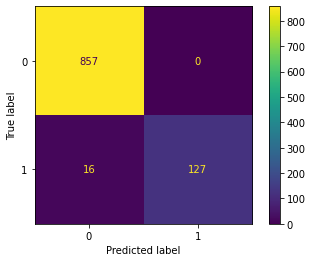

In [55]:
scores(voting_clf)

Here we see that the data performed well but it does perform as well as our boosted data.

In [56]:
for clf in (rf_model, best_DT_clf, xgb_model, gb_m):
    clf.fit(X_train_scaled, y_train)
    y_pred= clf.predict(X_test_scaled)
    print(clf, recall_score(y_test, y_pred))

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7,
                       n_estimators=1150) 0.7202797202797203
DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=5,
                       min_samples_split=5) 0.8881118881118881
XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:hinge', random_state=42, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 0.8881118881118881
GradientBoostingClassifier(random_state=42) 0.888111888

Since this data did not perform as well as the XGboost or the gradient boost, we decided that the ensemble would not be necessary for this data.

## Recommendations

Based on our original EDA from the first [notebook](01_syriatel_customer_churn_data_cleaning.ipynb) and the important features highlighted in the models above, we created three key recommendations to SyriaTel to improve churn:
1. Implement Fixed Fee Plan
2. Improve Customer Satisfaction
3. Prioritize Key States

We test our recommendations by applying them to the original dataset and run them through our model to predict the new churn status to see if churn decreases.

In [57]:
#print out original churn
round(df['churn'].value_counts(normalize=True)[1]*100,2)

14.49

### Implement Fixed Fee Plan

We know that total charge is one of the features of the dataset that has has high influence in our model. To adjust total charge, we can modify the charge per minute feature. Instead of adjusting the charge per minute for all types of calls, which could lead to a greater loss in revenue, we focused on day calls because our preliminary EDA showed that the charge per min for day calls were noticeably different between customers who churn and those who do not churn.

In [95]:
#create a new copy of the main data frame
new_df1 = df.copy()

In [59]:
#see the statistics for total day minutes and charge per min for day calls
new_df1[['total_day_minutes', 'charge_per_min_day']].describe()

,total_day_minutes,charge_per_min_day
count,3333.000000,3333.000000
mean,179.775098,0.318147
std,54.467389,0.124572
min,0.000000,0.000000
25%,143.700000,0.234490
50%,179.400000,0.304409
75%,216.400000,0.384510
max,350.800000,1.228000


In [60]:
#see the statistics for total day minutes and charge per min for day calls for those who churn
new_df1[new_df1['churn'] == 1][['total_day_minutes', 'charge_per_min_day']].describe()

,total_day_minutes,charge_per_min_day
count,483.000000,483.000000
mean,206.914079,0.364148
std,68.997792,0.158242
min,0.000000,0.000000
25%,153.250000,0.252803
50%,217.600000,0.348720
75%,265.950000,0.449143
max,350.800000,1.150000


In [61]:
#see the statistics for total day minutes and charge per min for day calls for those who do not churn
new_df1[new_df1['churn'] == 0][['total_day_minutes', 'charge_per_min_day']].describe()

,total_day_minutes,charge_per_min_day
count,2850.000000,2850.000000
mean,175.175754,0.310351
std,50.181655,0.116160
min,0.000000,0.000000
25%,142.825000,0.233230
50%,177.200000,0.299729
75%,210.300000,0.374728
max,315.600000,1.228000


<AxesSubplot:>

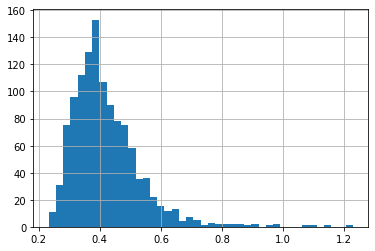

In [62]:
new_df1[new_df1['total_day_minutes'] > 200]['charge_per_min_day'].hist(bins='auto')

We see that the 50% percentile of total_day_minutes is ~200 minutes (we round down because if we were to promote this plan, we should have a rounded number) for customers who churn. We also see that the the price per minute at this percentile is ~$0.35. 

We suggest to implement a fixed fee plan for those who go over 200 minutes at a price of $0.35 per minute.

The gradient boost model was selected to be used here as the model had the best predictor for the training and testing data for the recall. The recall score was close unlike the XGboost where the training set performed far better than the test data.

We created the function below to allow us to test different minute and charge per minute parameters and how it affects churn.

In [63]:
def fixed_day_plan(df, day_min, charge_min_day):
    '''
    this function modifies the dataframe to adjust the charge_min_day to a fixed rate
    given a threshold for total_day_min, and returns the modified df and churn rate
    '''
    df.loc[df['total_day_minutes'] > day_min, 'charge_per_min_day'] = charge_min_day
    df['total_day_charge'] = df['charge_per_min_day'] * df['total_day_minutes']
    df['total_charge_dom'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']
    df['total_charge'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge'] + df['total_intl_charge']
    
    #seperating the target and data
    X = df.drop('churn', axis=1)
    y = df['churn']
    
    categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
    df_cat = X[categorical]
    df_cont = X.drop(categorical,axis = 1)
    
    #splitting the numericals and categoricals
    X_num = df_cont.columns
    X_cat = df_cat.columns
    
    #preprocessing the pipeline with standard scaler and one hot encoder
    numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
    catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

    pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])
    
    # transform the pipeline and then converting it back into a dataframe
    X_scaled = pp.fit_transform(X)
    
    #aggregating col names from the one hot encode 
    cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
    feature_names= list(X_num) + cat_names

    # renaming the data frame with corresponding col names
    X_scaled = pd.DataFrame(X_scaled, columns = feature_names)
    
    #Gradient Boost
    model_boost_gb = GradientBoostingClassifier(random_state=42)
    gb_m = model_boost_gb.fit(X_scaled,y)
    
    #predict the new churn from this dataframe
    df['churn'] = gb_m.predict(X_scaled)
    
    #calculate the new churn and total charge
    new_churn = round(df['churn'].value_counts(normalize=True)[1]*100, 2)
    
    return df, new_churn

In [64]:
new_df1, churn1 = fixed_day_plan(new_df1, 200, 0.35)
print(churn1)

12.57


After applying our fixed fee plan, churn decreased from 14.49% to 12-13%.

### Improve Customer Satisfaction

Here we want to see how we can improve churn rate by improving customer satisfaction for those who have a high call ratio to the customer support to their overall calls. We see that the most extreme case, a customer calls for support nearly 3% of all their calls.

<AxesSubplot:>

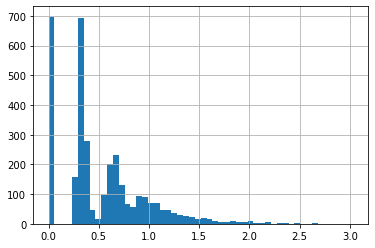

In [66]:
df['call_satisfaction'].hist(bins='auto')

In [67]:
df['call_satisfaction'].describe()

count    3333.000000
mean        0.519833
std         0.445629
min         0.000000
25%         0.289017
50%         0.366300
75%         0.727273
max         3.030303
Name: call_satisfaction, dtype: float64

We tested out what would happen if we capped the call_satisfaction ratio at the 75 percentile of 0.72. 

In [68]:
new_df2 = new_df1.copy()

We created the function below to allow us to test different customer satisfaction threshold and how it affects churn.

In [69]:
def call_satis(df, threshold, new_satis):
    df.loc[df['call_satisfaction'] > threshold, 'call_satisfaction'] = new_satis
    df['customer_service_calls'] = (df['call_satisfaction']/100)*df['total_calls']
    
    #seperating the target and data
    X = df.drop('churn', axis=1)
    y = df['churn']
    
    categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
    df_cat = X[categorical]
    df_cont = X.drop(categorical,axis = 1)
    
    #splitting the numericals and categoricals
    X_num = df_cont.columns
    X_cat = df_cat.columns
    
    #preprocessing the pipeline with standard scaler and one hot encoder
    numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
    catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

    pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])
    
    # transform the pipeline and then converting it back into a dataframe
    X_scaled = pp.fit_transform(X)
    
    #aggregating col names from the one hot encode 
    cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
    feature_names= list(X_num) + cat_names

    # renaming the data frame with corresponding col names
    X_scaled = pd.DataFrame(X_scaled, columns = feature_names)
    
    #Gradient Boost
    model_boost_gb = GradientBoostingClassifier(random_state=42)
    gb_m = model_boost_gb.fit(X_scaled,y)
    
    #predict the new churn from this dataframe
    df['churn'] = gb_m.predict(X_scaled)
    
    #calculate the new churn and total charge
    new_churn = round(df['churn'].value_counts(normalize=True)[1]*100, 2)
    
    return df, new_churn

In [77]:
new_df2, churn2 = call_satis(new_df2, 0.72, 0.72)
print(churn2)

9.81


We created a theoretical scenario where the customers who had a call rate over 0.72% were fixed at 0.72% on top of fixing the daycall rate above. This improved our churn rate even further and dropped it to about 10%.

### Prioritize Key States

We wanted to take a look at what is to be expected from these changes if they were to be rolled out to the five states with the highest churn rates. These states were NJ, CA, TX, MD, and SC.

In [83]:
new_df3 = new_df2.copy()
new_df4 = df.copy()

In [84]:
key_states = ['NJ', 'CA', 'TX', 'MD', 'SC']

In [91]:
def state_churn(df, state):
    new_df = df[df['state'] == state]
    churn = round(new_df['churn'].value_counts(normalize=True)[1]*100, 1)
    return churn

In [92]:
states = {}
for state in key_states:
    states[state] = [None, None]

for state in key_states:
    states[state][0] = state_churn(new_df4, state)
    states[state][1] = state_churn(new_df3, state)

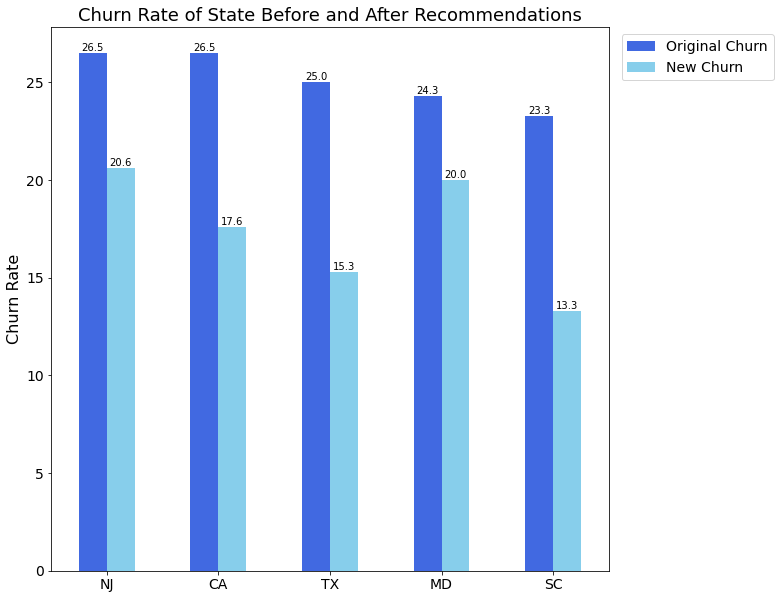

In [94]:
df2 = pd.DataFrame(states).T
df2.rename(columns={0:'Original Churn', 1: 'New Churn'}, inplace=True)
# plot grouped bar chart
fig, ax = plt.subplots(figsize=(10,10))

df2.plot(kind="bar", ax=ax, color=['royalblue','skyblue'])

#set labels for axes, and the x and y tick size
ax.set_title('Churn Rate of State Before and After Recommendations', fontsize=18)
ax.set_ylabel("Churn Rate", fontsize=16)
plt.xticks(size = 14, rotation=0)
plt.yticks(size = 14)
    
#reverse the legend labels so that it matches with the bar graphs
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 14})


for bar in ax.patches:
    # The text annotation for each bar should be its height
    bar_value = bar.get_height()
    text = f'{bar_value:,}'
    # Get the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # set the text
    ax.text(text_x, text_y, text, ha='center', va='bottom', color='black', size=10)
    
fig.savefig('images/Churn_Rate_of_State_Before_and_After_Recommendations.png', bbox_inches='tight')

When we applied these recommendations to these five states, we found that there was a significant drop in the churn rate to all the states. When these changes go through for these states, we can compare the results and see potentially how well our recommendations helped reduce the churn rate.

## Conclusions

## Next Steps

## Extra: Let's Create a Function to Calculate The Probability of a Customer Churning

### We wrote a function that takes in some parameters and when run returns the likelihood probability that that customer belongs to the churning class (probability that they churn)

In [ ]:
# single customer churning probability calculator

def churn(total_day_minutes, total_charge, customer_service_calls, international_plan):
    
    #using the ensemble to predict
    voting_clf = VotingClassifier(estimators=[ 
                                          ("rf", rf_model) ,
                                          ('dt', best_DT_clf),
                                          ('xgb', xgb_model),
                                          ("gb", gb_m)], 
                                          voting= "soft")
    
    #slice out corresponding df
    data= df[['total_day_minutes', 'total_charge', 
            'customer_service_calls','international_plan','churn'
              ]]
    
    
    #split into train test
    y= data['churn']
    X= data.drop('churn', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3 ,random_state=42)
    
    
    #pipeline reintroduced to fit specific data frame
    
    X_num=X_train.columns[:3]
    X_cat=X_train.columns[3:4]
    
    numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
    catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

    pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])
    
    
    #use pipeline to scale 
    X_train_scaled = pp.fit_transform(X_train)
    X_test_scaled= pp.transform(X_test)
    X_train_scaled= pd.DataFrame(X_train_scaled)
    X_test_scaled=pd.DataFrame(X_test_scaled)
    
#     create a single entry from function inputs to test
    d= {'total_day_minutes':total_day_minutes , 
        'total_charge': total_charge , 
        'customer_service_calls': customer_service_calls,
        'international_plan':international_plan}
    
    df_pred= pd.DataFrame(d, index=[0])
    
    #scale it so model doesnt break on string entries
    df_pred = pp.transform(df_pred)
    df_pred = pd.DataFrame(df_pred)
    
    #fit the model
    voting_clf.fit(X_train_scaled, y_train)
  
    #predict the probability that customer may churn
    p = voting_clf.predict_proba(df_pred)
    
   
    
    print(f"The selected account has a {round(p[0][1]*100)}% chance of churning ")
    

In [ ]:
df



So below is the churn rate for someone that has 200 day minutes, 34$ total charge and 0 customer calls with an international plan

In [ ]:
churn(200,34,0,"yes")

In [ ]:
# example used for one customer
churn(128,75.56,1,"no")

### Let's select a random person in the data and use the function

In [ ]:
df.loc[193]

In [ ]:
churn(94,51.02,0,"no")